# Helpers

In [1]:
!pip install feature-engine
import pandas as pd
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from feature_engine.creation import CyclicalFeatures
from scipy import stats

import pickle

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd drive/MyDrive/IS4303/notebooks/new_cleaned

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.4/319.4 kB 5.7 MB/s eta 0:00:00
Mounted at /content/drive
/content/drive/MyDrive/IS4303/notebooks/new_cleaned


In [2]:
df = pd.read_csv("https://drive.google.com/uc?export=download&id=1i-JbDm2nY15NnYl62GxlsBCoELp1HJZ3") # original dataset

def transform_test_df(data):
  data = data.copy()
  data['country'].fillna(f'unknown', inplace=True)
  data['agent'].fillna(0, inplace=True)
  data['company'].fillna(0, inplace=True)
  data['children'].fillna(0, inplace=True)
  data = data.drop_duplicates(keep="first")
  data = data[data['country'] != 'unknown']
  return data

df = transform_test_df(df)
df = df[df['hotel'] == 'Resort Hotel']

cleaned_1 = pd.read_csv('1cleaned.csv')
pre_cols = ['hotel', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'customer_type', 'deposit_type']
pre_ohe = pd.get_dummies(cleaned_1[pre_cols], prefix=pre_cols)
cleaned_2 = pd.read_csv('2cleaned.csv')
col_list = cleaned_2.columns

with open('FittedCyclicalEncoder.pkl', 'rb') as f:
  cyclical = pickle.load(f)
  
# just need class definition to load pipeline
class Cleaner(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass
  
  def transform(self, X):
    X = X.copy()

    X = X.drop(columns=['arrival_date_year', 'reservation_status', 'reservation_status_date', 'arrival_date_day_of_month'])

    X['country'].fillna(f'unknown', inplace=True)
    X['agent'].fillna(0, inplace=True)
    X['company'].fillna(0, inplace=True)
    X['children'].fillna(0, inplace=True)

    X = X.drop_duplicates(keep="first")

    X = X.drop(columns=['company'])
    X = X.drop(columns=['agent'])

    X = X[X['country'] != 'unknown']
    return X

class Encoder(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass

  def add_missing_columns(self, X):
    missing_columns = [col for col in pre_ohe if col not in X.columns]
    if missing_columns:
      df_missing = pd.DataFrame(0, index=X.index, columns=missing_columns)
      X = pd.concat([X, df_missing], axis=1)
    return X
  
  def transform(self, X):
    X = X.copy()

    cols = ['hotel', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'customer_type', 'deposit_type']
    ohe = pd.get_dummies(X[cols], prefix=cols)
    X = pd.concat([X, ohe], axis=1)
    X = X.drop(cols, axis=1)
    X = self.add_missing_columns(X)

    if 'is_canceled' not in X:
      X['is_canceled'] = 0 # doesn't matter, just because cyclical expects this after fitting

    months = {"JANUARY" : 1,"FEBRUARY" : 2,"MARCH" : 3,"APRIL": 4, "MAY": 5, "JUNE": 6, "JULY": 7, "AUGUST": 8, "SEPTEMBER": 9, "OCTOBER": 10, "NOVEMBER": 11, "DECEMBER": 12}
    X['arrival_date_month'] = X['arrival_date_month'].apply(lambda x: months[str(x).upper()])

    X.drop(X.columns.difference(col_list), 1, inplace=True)

    cyclical_features_X = cyclical.transform(X)
    cos_only = cyclical_features_X.drop(["arrival_date_month_sin", "arrival_date_week_number_sin"], axis=1)

    X = cos_only.drop(columns=['is_canceled'])
    return X

with open('Pre_Pipeline.pkl', 'rb') as f:
  pipeline = pickle.load(f)

with open('model.pkl', 'rb') as f:
  model = pickle.load(f)

# Overbooking

In [3]:
def get_proba(data, pipeline, model):
  data = data.copy()
  data = pipeline.transform(data)
  probas = model.predict_proba(data)[:,1]
  return probas

In [4]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


def optimise_overbooking(df, pipeline, model, hard_capacity=50, date_col='arrival_date'):
  df = df.copy()
  df[date_col] = pd.to_datetime(df[[date_col + '_year', date_col + '_month', date_col + '_day_of_month']].astype(str).agg('-'.join, axis=1))
  
  probas = get_proba(df, pipeline, model)
  df['cancellation_proba'] = probas

  daily_bookings = df.groupby(date_col).size().reset_index(name='num_bookings')
  daily_bookings['free_capacity'] = hard_capacity - daily_bookings['num_bookings']
  
  daily_cancel_probs = df.groupby(date_col)['cancellation_proba'].mean().reset_index(name='avg_cancel_proba')
  daily_data = pd.merge(daily_bookings, daily_cancel_probs, on=date_col)

  daily_data['overbooking_tolerance'] = (daily_data['avg_cancel_proba'] * daily_data['num_bookings']).astype(int)

  daily_data['adjusted_free_capacity'] = daily_data['free_capacity'].apply(lambda x: max(x, 0))
  daily_data['excess_bookings'] = -daily_data['free_capacity'].apply(lambda x: min(x, 0))

  daily_data['adjusted_overbooking_tolerance'] = daily_data['overbooking_tolerance'] - daily_data['excess_bookings']
  daily_data['adjusted_overbooking_tolerance'] = daily_data['adjusted_overbooking_tolerance'].apply(lambda x: max(x, 0))

  result = daily_data[[date_col, 'adjusted_free_capacity', 'adjusted_overbooking_tolerance']]
  
  fig, ax = plt.subplots(figsize=(12, 6))
  ax.bar(result[date_col], result['adjusted_free_capacity'], color='blue', label=f'Free capacity with max={hard_capacity}')
  ax.bar(result[date_col], result['adjusted_overbooking_tolerance'], color='orange', label='Overbooking tolerance', bottom=result['adjusted_free_capacity'])
  plt.xlabel('Date', fontsize=14)
  plt.ylabel('Capacity', fontsize=14)
  plt.title('Overbooking optimisation', fontsize=16)
  plt.legend(fontsize=14)
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=16)
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
  ax.grid(axis='y', linestyle='--', alpha=0.7)
  plt.tight_layout()
  plt.show()
  
  return result

<ipython-input-2-48825be929ac>:74: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X.drop(X.columns.difference(col_list), 1, inplace=True)
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


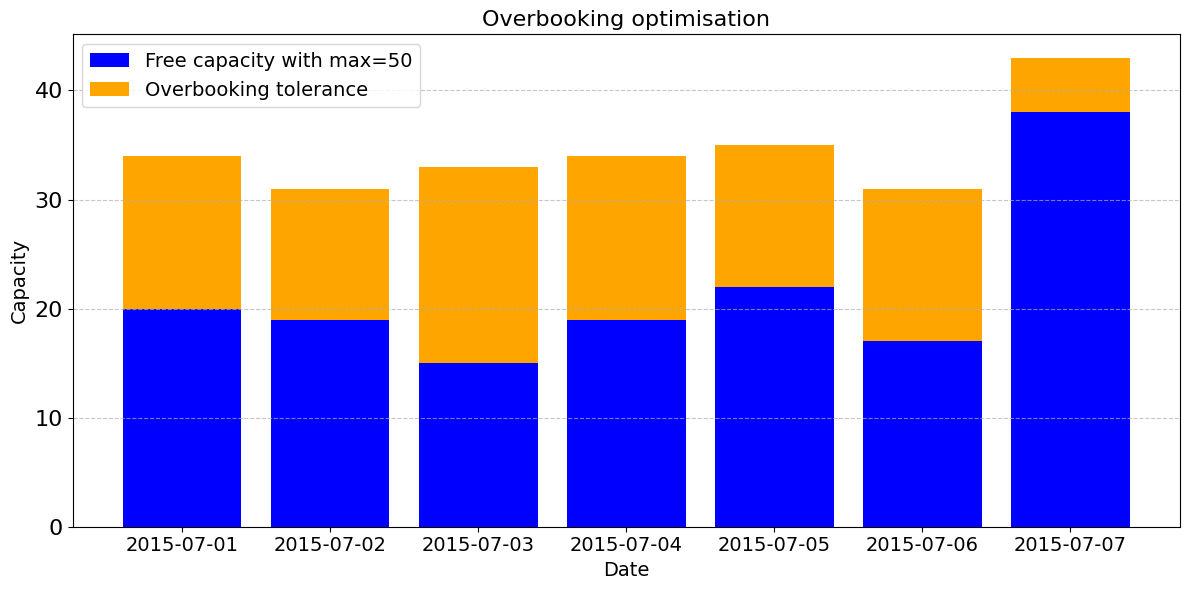

,arrival_date,adjusted_free_capacity,adjusted_overbooking_tolerance
0,2015-07-01,20,14
1,2015-07-02,19,12
2,2015-07-03,15,18
3,2015-07-04,19,15
4,2015-07-05,22,13
5,2015-07-06,17,14
6,2015-07-07,38,5


In [6]:
optimise_overbooking(df.head(200), pipeline, model)